In [1]:
import gc
import os
from Project2_LSTM.load_data import AudioTrainDataset, PaddingZeros, CustomSpectogram

import matplotlib.pyplot as plt
import numpy as np
import torch
from IPython.display import Audio
from torch.utils.data import DataLoader
from torchaudio.transforms import Spectrogram
from torchvision.transforms import Compose
from tqdm import tqdm

In [3]:
device = torch.device("cuda")

DATA_PATH = os.path.join("tensorflow-speech-recognition-challenge", "train", "audio")

In [4]:
dataset = AudioTrainDataset(DATA_PATH)
(wave, sample_rate), label = dataset[3456]

In [5]:
labels_list, labels_dict = dataset.find_classes(DATA_PATH)
labels_dict = {idx: name for name, idx in labels_dict.items()}
labels_dict

{1: 'bed',
 2: 'bird',
 3: 'cat',
 4: 'dog',
 5: 'down',
 6: 'eight',
 7: 'five',
 8: 'four',
 9: 'go',
 10: 'happy',
 11: 'house',
 12: 'left',
 13: 'marvin',
 14: 'nine',
 15: 'no',
 16: 'off',
 17: 'on',
 18: 'one',
 19: 'right',
 20: 'seven',
 21: 'sheila',
 22: 'silence',
 23: 'six',
 24: 'stop',
 25: 'three',
 26: 'tree',
 27: 'two',
 28: 'up',
 29: 'wow',
 30: 'yes',
 31: 'zero'}

In [6]:
wave.shape

torch.Size([1, 16000])

In [7]:
label

3

Text(0.5, 1.0, 'Example wavefile for class cat')

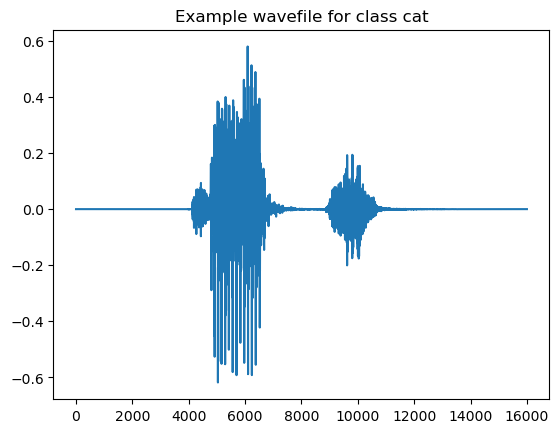

In [8]:
plt.plot(wave[0].numpy())
plt.title(f"Example wavefile for class {labels_dict[label]}")

In [9]:
Audio(wave, rate=sample_rate)

## Padding with 0 for constant length

Not all samples have equal length. 6469 samples are shorter than 16 000 points, other are exactly equal 16 000.

In [10]:
sizes = [0] * (len(dataset) // 20)
for i in tqdm(range((len(dataset) // 20))):
    sizes[i] = dataset[i][0][0][0].shape

100%|██████████| 3256/3256 [00:00<00:00, 4774.20it/s]


In [11]:
s, counts = np.unique([sizes], return_counts=True)

In [12]:
s[-1], sum(counts[:-1])

(16000, 421)

In [13]:
pad = PaddingZeros(16000)
sizes = [0] * (len(dataset) // 20)
for i in tqdm(range(len(dataset) // 20)):
    sizes[i] = pad(dataset[i][0])[0][0].shape

100%|██████████| 3256/3256 [00:00<00:00, 5234.74it/s]


In [14]:
np.unique(sizes)

array([16000])

## Transformations

Plotting and transformations of a sample.

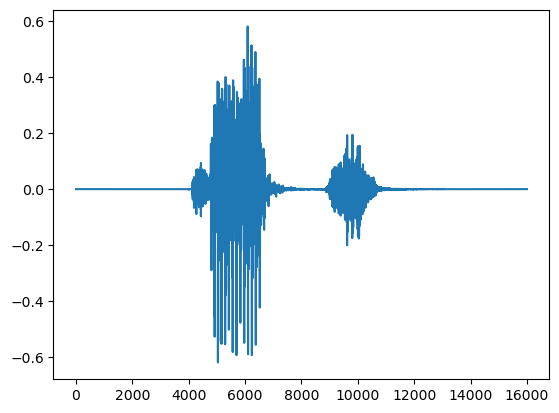

In [15]:
plt.plot(wave[0].numpy())

In [16]:
spect = torch.log(Spectrogram(n_fft=1024, power=2)(wave))
spect.shape

torch.Size([1, 513, 32])

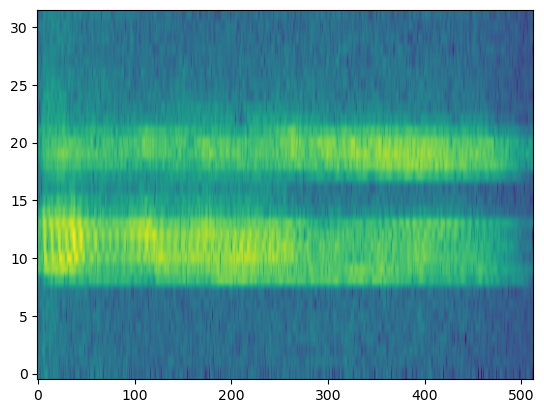

In [17]:
plt.imshow(spect[0].numpy().T, aspect='auto', origin='lower')

## Simple LSTM model

In [18]:
transforms = Compose([
    PaddingZeros(16000),
    CustomSpectogram(n_fft=1024, power=2)
])
features_dataset = AudioTrainDataset(DATA_PATH, transform=transforms)

In [19]:
data_loader = DataLoader(features_dataset, batch_size=72, num_workers=2, shuffle=True,
                         generator=torch.random.manual_seed(123))

In [20]:
for (wave, sample_rate), label in data_loader:
    print(torch.squeeze(wave).shape)
    break

torch.Size([72, 513, 32])


In [21]:
class MyLSTM(torch.nn.Module):
    def __init__(self, input_size, hidden_size, target_size):
        super().__init__()
        self.lstm = torch.nn.LSTM(input_size, hidden_size, num_layers=1)
        self.hidden2label = torch.nn.Linear(hidden_size, target_size)
        self.softmax = torch.nn.Softmax(dim=-1)

    def forward(self, x):
        x_transposed = torch.permute(x.squeeze(), (1, 0, 2))
        lstm_out, _ = self.lstm(x_transposed)
        label_space = self.hidden2label(lstm_out[-1])
        return self.softmax(label_space)

In [22]:
len(data_loader)

905

In [26]:
model = MyLSTM(32, 32, 31).to(device)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

for epoch in range(10):
    for batch_no, ((wave, sample_rate), label) in tqdm(enumerate(data_loader)):
        model.zero_grad()
        y = torch.nn.functional.one_hot(label - 1, 31).to(torch.float32).to(device)
        y_hat = model(wave.to(device))

        l = loss(y_hat, y)
        l.backward()
        optimizer.step()

905it [00:19, 47.28it/s]
905it [00:19, 47.13it/s]
905it [00:19, 47.56it/s]
905it [00:18, 47.77it/s]
905it [00:19, 47.59it/s]
905it [00:18, 47.85it/s]
905it [00:19, 47.00it/s]
905it [00:19, 47.56it/s]
905it [00:19, 47.38it/s]
905it [00:19, 46.61it/s]


In [27]:
wave = 1

In [28]:
gc.collect()

2743